In [7]:
from forward_integration import *

In [8]:
# ========================================== #
# =============== INTEGRATION =============== #
# ========================================== #



def cell_division_binomial(cell, cells, var_dx, var_dg, mean_lambda, mean_q, growth_noise=False, q_noise=False, beta=0):
    """ 
    Calculates the first x and g for the daughter cells of the cell and overwrites the values in the respective cells
    Parameters:
    cell (Cell): current cell
    cells (list of Cell): all cells
    var_dx (float): as in ggp, 'None' to turn noise off
    var_dg (float): as in ggp, 'None' to turn noise off
    
    Returns:
    None
    """
    lt = get_lambda(cell, 0)

    if q_noise:
        qt = get_q(cell, 0)
    else:
        qt = mean_q
    cell.qt[-1] = qt
    
    dt = cell.time[-1]-cell.time[-2] # not quite accurate

    x = cell.log_length[-1] + lt*dt
    g = cell.gfp[-1]*np.exp(-beta*dt) + qt*np.exp(cell.log_length[-1])/(lt+beta) * (np.exp( (lt+beta) *dt) -1)
    
    ## Enforce c_d == c_m
    # x = cell.log_length[-1]
    # g = cell.gfp[-1]

    d_cells = get_daughters_idx(cell, cells)

    if d_cells[0] != None:
        x_d1 = cells[d_cells[0]].log_length[0] 
        if var_dg==None:
            g_d1 = g * np.exp(x_d1 - x)
        else:
            g_d1 = np.random.binomial(g, np.exp(x_d1 - x))
        cells[d_cells[0]].gfp[0] = g_d1

    if d_cells[1] != None:
        x_d2 = cells[d_cells[1]].log_length[0] 
        if var_dg==None:
            g_d2 = g * np.exp(x_d2 - x)
        else:
            g_d2 = g-g_d1
        cells[d_cells[1]].gfp[0] = g_d2

    return cell


def cell_division_data(cell, cells, cells_prediction, 
                       mean_lambda, mean_q, growth_noise, q_noise, beta=0):
    """ 
    Calculates the first x and g for the daughter cells of the cell and overwrites the values in the respective cells
    
    Returns:
    cell
    """
    
    m_pred = get_cell_by_id(cell.cell_id, cells_prediction)  # mother cell with prediction values
    d_cells = get_daughters_idx(cell, cells) # daughter cell(s) with prediction values, can be 0,1 or 2 entries
    
    # calculate first daughter cell if present
    if d_cells[0] != None:
        d1_pred = get_cell_by_id(cells[d_cells[0]].cell_id, cells_prediction) # fetch the daughter cell from the "prediction" cells
        x_ratio = d1_pred.log_length[0] - m_pred.log_length[-1]                 # ratio of daughter/mother cell lengths
        g_ratio = d1_pred.gfp[0] / m_pred.gfp[-1]                               # ratio of daughter/mother cell gfp
        
        cells[d_cells[0]].log_length[0] = cell.log_length[-1] + x_ratio 
        cells[d_cells[0]].gfp[0] = cell.gfp[-1] * g_ratio 

    if d_cells[1] != None:
        d2_pred = get_cell_by_id(cells[d_cells[1]].cell_id, cells_prediction)
        x_ratio = d2_pred.log_length[0] - m_pred.log_length[-1]                 # ratio of daughter/mother cell lengths
        g_ratio = d2_pred.gfp[0] / m_pred.gfp[-1]                               # ratio of daughter/mother cell gfp
        
        cells[d_cells[1]].log_length[0] = cell.log_length[-1] + x_ratio 
        cells[d_cells[1]].gfp[0] = cell.gfp[-1] * g_ratio 
    return cell

        

## For a given cell do the actual integration
def single_cell_integration(cell, mean_lambda, mean_q, growth_noise=False, q_noise=False, beta=0):
    for i, t in enumerate(cell.time):
        lt = get_lambda(cell, i)

        if q_noise:
            qt = get_q(cell, i)
        else:
            qt = mean_q
            
        if i == 0:
            pass
        else:
            dt = cell.time[i] - cell.time[i-1]  
            gfp = cell.gfp[i-1]*np.exp(-beta*dt) + qt*np.exp(cell.log_length[i-1])/(lt+beta) * (np.exp( (lt+beta) *dt)-1)
            cell.gfp[i] = gfp
            cell.qt[i-1] = qt
        if cell.gfp[i]<0: 
            cell.gfp[i] = 0
    return cell
         
    
## recursicvely go through the cells starting at a root 
def go_through_cell_tree(cell, 
                         cells, 
                         cells_prediction,
                         mean_lambda, 
                         mean_q, 
                         growth_noise, 
                         q_noise,
                         var_dx,
                         var_dg,
                         beta):
    if cell == None:
        return None
    d_cells = get_daughters(cell, cells)
    
    cell = single_cell_integration(cell, 
                                    mean_lambda, 
                                    mean_q, 
                                    growth_noise=growth_noise, 
                                    q_noise=q_noise, 
                                    beta=beta)

    if var_dx=="data" and var_dg=="data":
        cell = cell_division_data(cell, cells, cells_prediction, mean_lambda, mean_q, growth_noise, q_noise, beta)
    else:
        cell = cell_division_binomial(cell, cells, var_dx, var_dg, mean_lambda, mean_q, growth_noise, q_noise, beta)

    go_through_cell_tree(d_cells[0], cells, cells_prediction, mean_lambda, mean_q, growth_noise, q_noise, var_dx, var_dg, beta)
    go_through_cell_tree(d_cells[1], cells, cells_prediction, mean_lambda, mean_q, growth_noise, q_noise, var_dx, var_dg, beta)



## Integration "main" 
def forward_integration(cells_prediction, parameters, growth_noise=False, q_noise=False, var_dx=None, var_dg=None, beta=0):
    """ 
    Forward integration using the lambda and q from a data set
    
    Parameters:
    cells_prediction (list Cell): cells read from a prediction file
    parameters (dict): parameters read from prediction file for mean_lambda and mean_q
    growth_noise (bool): if True, use the inferred lambda, if False lambda is fixed to mean_lambda
    q_noise (bool): if True, use the inferred q, if False lambda is fixed to mean_q
    var_dx (float or None): None turns off noise in cell size split at division. 
                            If float value, var_dx is variance of Gaussian 
    var_dg (float or None): None turns off binomial sampling at division.
                            If float value, var_dg is scaling binomial variance 
    
    Returns:
    list of cells as input, but with overwritten log_length, gfp, lt, and qt
    """
    mean_lambda = np.sum(np.concatenate([np.array(cell.lt)/np.array(cell.cov_ll) for cell in cells_prediction])) \
                    /np.sum(np.concatenate([1./np.array(cell.cov_ll) for cell in cells_prediction]))
    # print("mean_lambda", mean_lambda, parameters["mean_lambda"])
    mean_q =  np.sum(np.concatenate([np.array(cell.qt)/np.array(cell.cov_qq) for cell in cells_prediction])) \
                    /np.sum(np.concatenate([1./np.array(cell.cov_qq) for cell in cells_prediction]))
    # print("mean_q", mean_q, parameters["mean_q"])

    cells_integrated = copy.deepcopy(cells_prediction)
    idx_roots = get_roots(cells_prediction)
    

    for i in idx_roots: 
        # these 2 lines are a reminder how i initialise x and g
        cells_integrated[i].log_length[0] = cells_integrated[i].log_length[0]
        
        steady_state_concentration = mean_q/(mean_lambda+beta)
        # steady_state_concentration = np.mean(np.concatenate([np.array(cell.gfp)/np.exp(cell.log_length) for cell in cells_prediction]))

        # cells_integrated[i].gfp[0] = cells_integrated[i].gfp[0]
        if q_noise:
            cells_integrated[i].gfp[0] = cells_integrated[i].gfp[0]
        else:
            cells_integrated[i].gfp[0] = steady_state_concentration * np.exp(cells_integrated[i].log_length[0])

        go_through_cell_tree(cells_integrated[i], 
                             cells_integrated, 
                             cells_prediction, 
                             mean_lambda, 
                             mean_q, 
                             growth_noise=growth_noise, 
                             q_noise=q_noise,
                             var_dx=var_dx,
                             var_dg=var_dg, 
                             beta=beta)
    return cells_integrated
    
   

In [9]:
def get_input_files(directory, keyword=None, ext=".csv"):
    entries = os.listdir(directory)
    final_files = []
    if keyword == None:
        for e in entries:
            if e.endswith(ext):
                final_files.append(os.path.join(directory,e))
    else:
        for e in entries:
            if e.endswith(ext) and keyword in e:
                final_files.append(os.path.join(directory,e))   
    return sorted(final_files)   

### get data and set output dir
input_dir = "../../fluctuations_paper_data/first_replicates_autofl_corrected/"
data_files = get_input_files(input_dir, keyword='prediction.csv')

len(data_files)

23

In [10]:
def scale_q(cells, s):
    for i, cell in enumerate(cells):
        cells[i].qt = np.multiply(cell.qt, s)
        cells[i].cov_qq = np.multiply(cell.cov_qq, s**2)
        cells[i].gfp = np.multiply(cell.gfp, s)
    return cells

integrating: acetate005_hi1_20230228

integrating: acetate005_hi3_20230228

integrating: acetate005_med2_20230223


/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)
/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)



integrating: acetate005_med3_20230428

integrating: acetate005_rplN_20230228

integrating: acetate005_rrnB_20230228

integrating: glucose020_hi1_20190515

integrating: glucose020_hi3_20190529

integrating: glucose020_med2_20190515


/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)
/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)



integrating: glucose020_med3_20190529


/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)
/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)
/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)



integrating: glucose020_rplN_20190529

integrating: glucose020_rrnB_20230413

integrating: glucoseaa020_hi1_20220921

integrating: glucoseaa020_hi3_20221111

integrating: glucoseaa020_med2_20220921


/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)
/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)
/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)



integrating: glucoseaa020_rplN_20221111

integrating: glucoseaa020_rrnB_20220921

integrating: glycerol040_hi1_20190515

integrating: glycerol040_hi3_20190529

integrating: glycerol040_med2_20190515


/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)
/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)



integrating: glycerol040_med3_20190529


/Users/bjoern/mother_machine/ggp_notebooks/simulations/forward_integration.py:319: RuntimeWarning: divide by zero encountered in log
  _, bin_edges_both = np.histogram(np.log(np.append(conc_real,conc_int )), density=False, bins=100)



integrating: glycerol040_rplN_20190529

integrating: glycerol040_rrnB_20230413



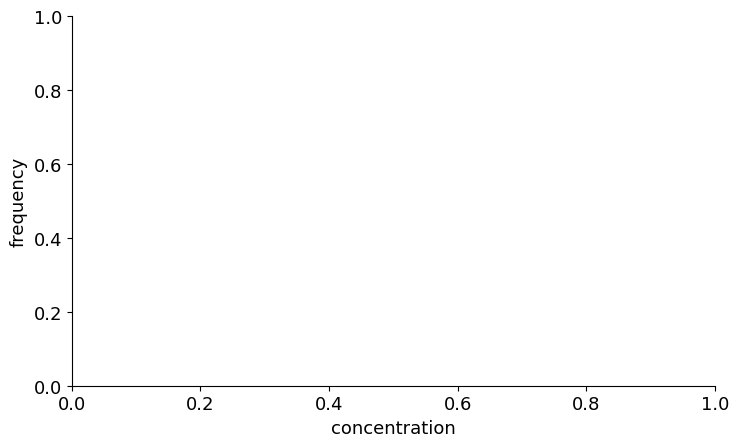

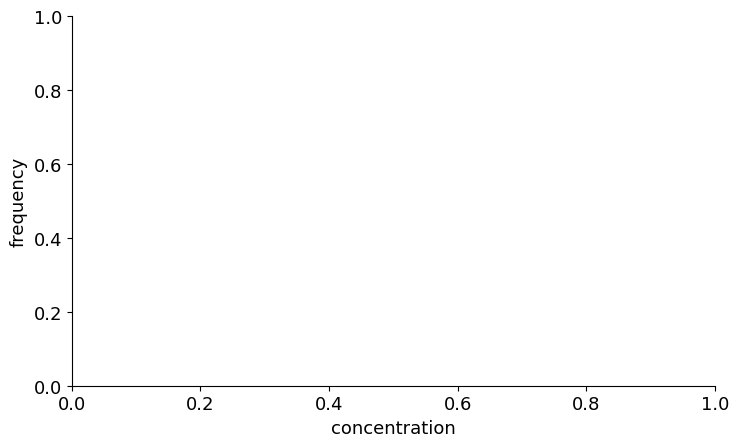

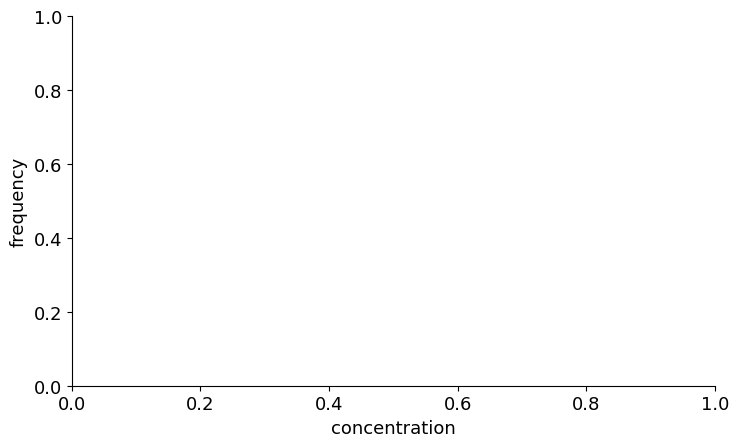

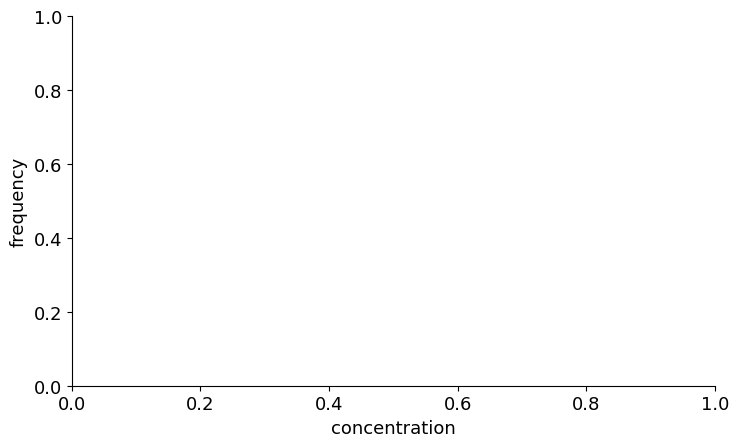

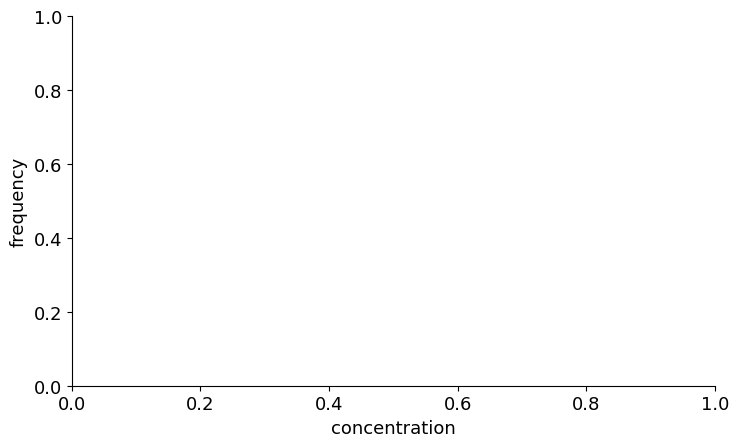

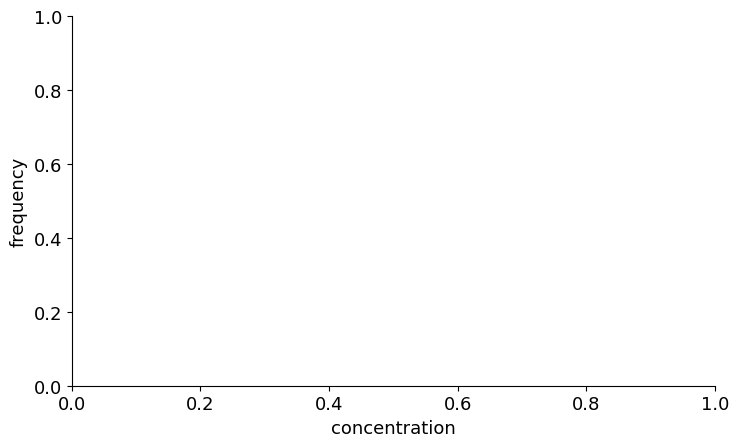

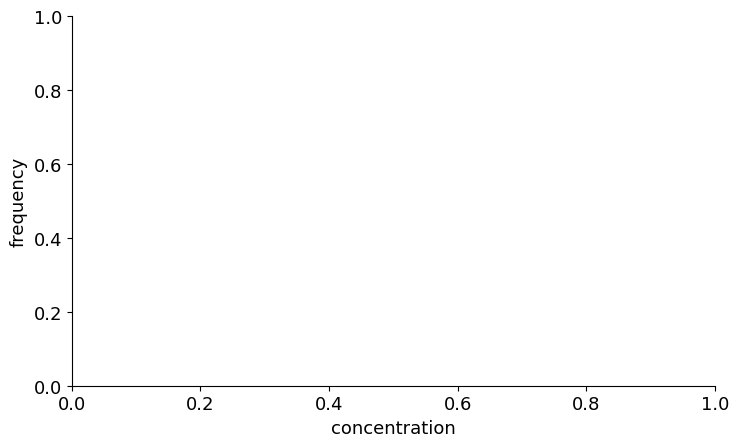

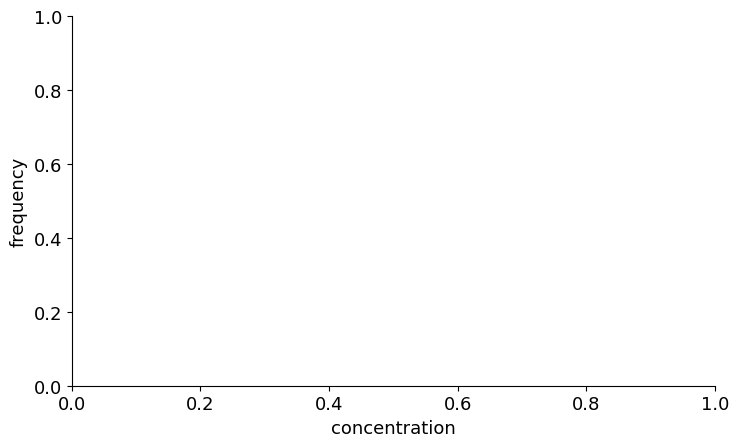

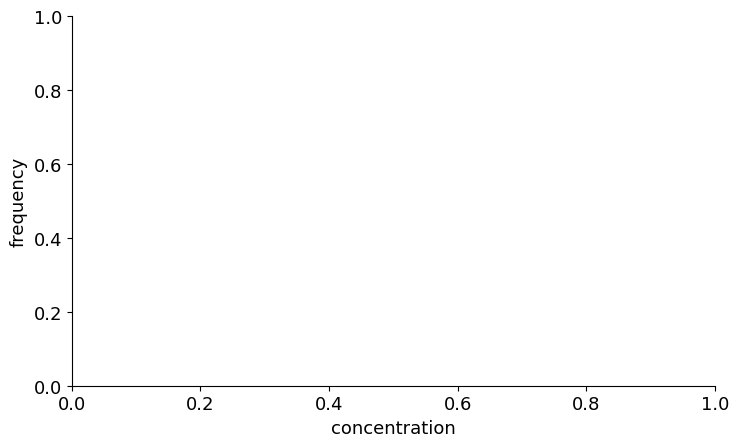

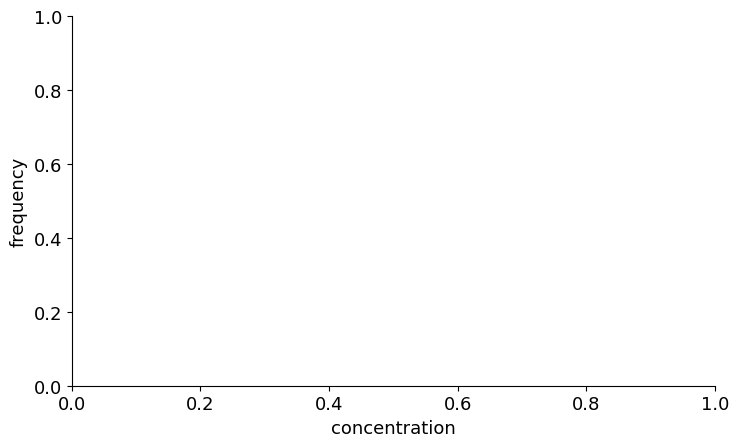

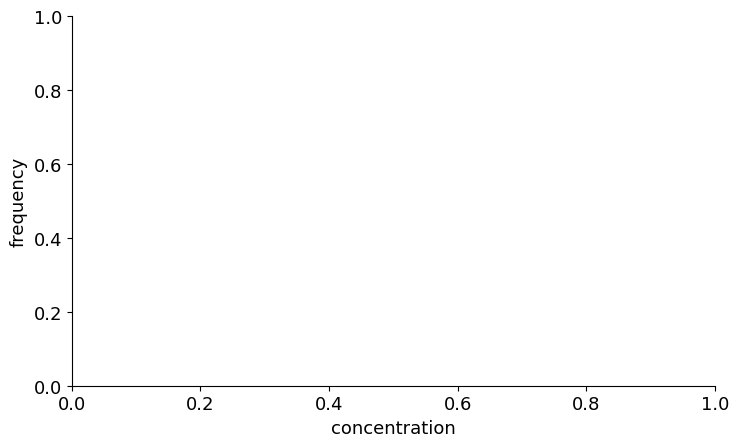

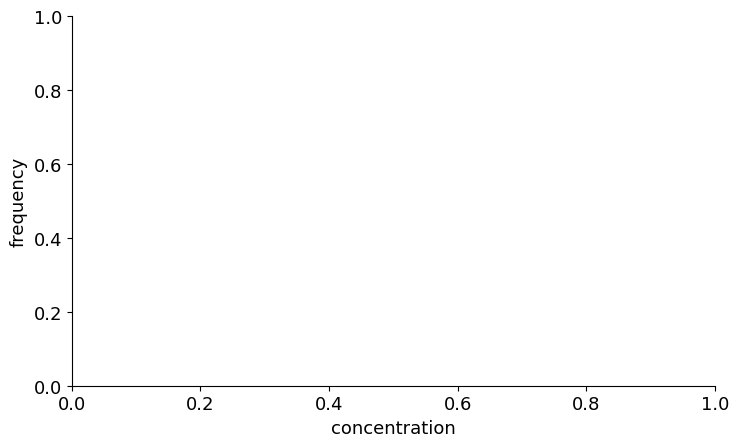

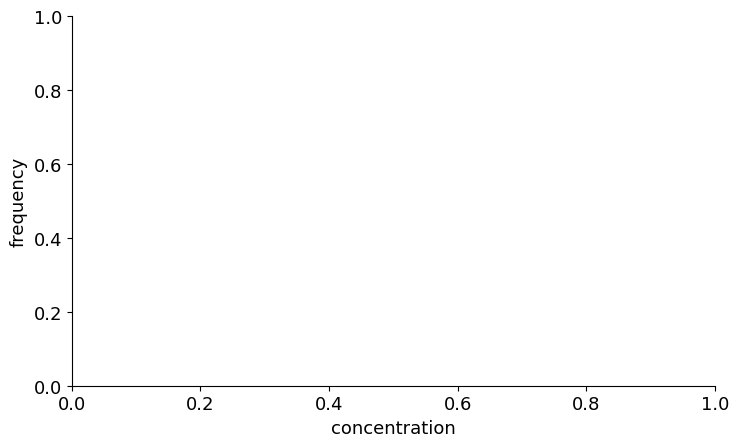

In [19]:
"""
HOW TO SET THE SETTING PARAMAETERS
----------------------------------

- growth_noise and q_noise can be either True or False, 
where True will take the inferred lambda/q traces and False takes the mean growth/production rate

-var_dx and var_dg can be either a float, None or "data":
        - float: will enable the binomial sampling noise in gfp and gaussian sampling in log_length with therespective parameters
        - None: will turn off the noise source
        - "data": will 'measure' the ratio in length and gfp of mother and daughter cell in the data and transfer it to the simulation

"""
for data_file in sorted(data_files):
    sample = '_'.join(data_file.split('/')[-1].split('_')[:3])
    print("integrating:", sample)
    cells_prediction = ggp_df2cells(pd.read_csv(data_file, skiprows=header_lines(data_file)))
    cells_raw = ggp_df2cells(pd.read_csv(data_file, skiprows=header_lines(data_file)), log_length="log_length", gfp="fp")
    params = read_header(data_file)

    out_dir = mk_missing_dir(os.path.join(*data_file.split('/')[:-2], 'integration', sample), depth=1)

    #### inferred var_dx, var_dg
    var_dx = params["var_dx"][1]
    var_dg = params["var_dg"][1]
    beta   = params["beta"][1]
    

    settings = {"1": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                "0.5": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                "0.25": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                "0.125": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                "0.0625": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                "0.03125": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                "0.015625": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                "0.0078125": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                "0.00390625": {"growth_noise": True, 
                        "q_noise": True, 
                        "var_dx": "data", 
                        "var_dg": True},
                        }
    

    # r
    for s in settings.keys():
        # print(s, end=" ")
        cells = copy.deepcopy(cells_prediction)
        cells = scale_q(cells, float(s))
        out_dir_s = mk_missing_dir(os.path.join(out_dir, s), depth=1)
        cells_integrated = forward_integration(cells, params, 
                                               growth_noise=True, 
                                               q_noise=True, 
                                               var_dx="data", 
                                               var_dg=True, 
                                               beta=beta)

        outfile_base = os.path.join(out_dir_s, sample)+'_'+s
        outfile_base = '_'.join(outfile_base.split()) # remove whitespaces
        
        save_cells(cells_integrated, outfile_base+'.csv')
        # plots
        plot_concentration(cells_integrated, cells,  get_longest_path(cells_integrated), cells_raw=None,
                           label_i=s,plot_file = outfile_base+'.pdf')
        plot_x_g(cells_integrated, cells,  get_longest_path(cells_integrated), cells_raw=None,
                           label_i=s,
                          plot_file = outfile_base+'_x_g.pdf')
        try:
                plot_concentration_hist(cells_integrated, cells,
                                label_i=s, log=False,
                                plot_file = outfile_base+'_hist.pdf')
                plot_concentration_hist(cells_integrated, cells,
                                label_i=s,
                                plot_file = outfile_base+'_log_hist.pdf')
        except:
             pass
    print()
        
        